<a href="https://colab.research.google.com/github/saarthag/Qualcomm-AV-DL-Hackathon/blob/main/model_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/saarthag/Qualcomm-AV-DL-Hackathon.git

Cloning into 'Qualcomm-AV-DL-Hackathon'...
remote: Enumerating objects: 2235, done.
remote: Counting objects: 100% (2235/2235), done.
remote: Compressing objects: 100% (2232/2232), done.
remote: Total 2235 (delta 3), reused 2230 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (2235/2235), 28.82 MiB | 11.80 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [12]:
import os
from torchvision.io import decode_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [13]:
class EmergencyVehiclesDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
      img_path = os.path.join(self.img_dir, self.img_labels.iat[idx, 0])
      image = decode_image(img_path)
      label = self.img_labels.iloc[idx, 1]
      if self.transform:
        image = self.transform(image)
      if self.target_transform:
        label = self.target_transform(label)
      return image, label

In [14]:
train_dataset = EmergencyVehiclesDataset('/content/Qualcomm-AV-DL-Hackathon/train.csv', '/content/Qualcomm-AV-DL-Hackathon/images/')

In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])
<class 'torch.Tensor'> <class 'torch.Tensor'>


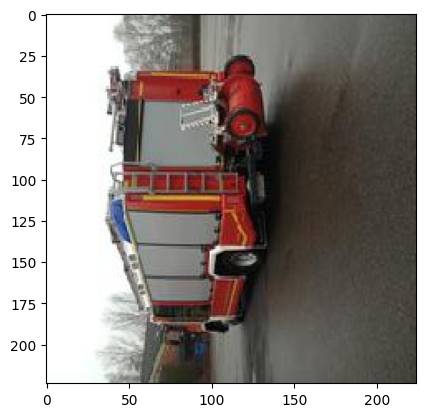

Label: 1


In [17]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(type(train_features), type(train_labels))
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T, cmap="gray")
plt.show()
print(f"Label: {label}")